# Patient calibration workflow using AutoEmulate

## Introduction


## The Naghavi cardiovascular model

The Naghavi lumped parameter model is a mathematical model of the human cardiovascular system, designed to simulate the dynamics of blood flow and pressure throughout the heart and circulatory system using lumped parameter modeling. 
A **lumped parameter model** simplifies the cardiovascular system by dividing it into compartments (or "lumps") such as:

- Heart chambers (left and right atria and ventricles)
- Major blood vessels (aorta, vena cava, pulmonary arteries and veins)
- Systemic and pulmonary circulations

Each compartment is modeled using analogies to electrical circuits:

- Pressure ↔ Voltage
- Flow ↔ Current
- Resistance ↔ Vascular resistance (R\)
- Compliance ↔ Vessel elasticity or capacitance (C\)
- Inertance ↔ Blood inertia (L)

This approach allows simulation of the time-dependent relationships between pressure, volume, and flow rate across the entire cardiovascular system using ordinary differential equations (ODEs).

The Naghavi lumped parameter model is a mathematical model of the human cardiovascular system, designed to simulate the dynamics of blood flow and pressure throughout the heart and circulatory system using lumped parameter modeling. 
A **lumped parameter model** simplifies the cardiovascular system by dividing it into compartments (or "lumps") such as:

## Patient calibration workflow

In this tutorial, we present a three-stage workflow for calibrating the Naghavi model to patient-specific clinical data using AutoEmulate. The process has the following stages:

- First we perform a global sensitivity analysis, which identifies the most influential parameters affecting model outputs and reduces the dimensionality of the calibration problem. 
- Next, we apply history matching, a sequential uncertainty quantification technique that uses emulators to efficiently rule out implausible regions of the parameter space based on observed patient data. This results in a restricted, plausible region—known as the NROY (Not Ruled Out Yet) space—where parameters are consistent with the clinical measurements within acceptable uncertainty bounds. 
- Finally, we perform Bayesian inference within this NROY region to estimate the full posterior distribution of the remaining parameters, capturing the most likely values and their associated uncertainty. 

### Global sensitivity analysis

The Naghavi model has 16 parameters which makes individual patient calibration challenging. To address this we use a emulator-based global sensitivity analysis to quantify the influence each parameter on features derived from left ventricle artery pressure. This approach reduces the parameters that will be used in model personalization from 16 to 5.

In [1]:
import pandas as pd
import torch

from autoemulate.data.utils import set_random_seed
seed = 42
set_random_seed(seed)


#### Set up simulator and generate data

For this tutorial we use `ModularCirc` a package that providse a framework for building 0D models and simulating cardiovascular flow and mechanics. The `NaghaviSimulator` simulates pressure traces, we then choose to output summary statistics for each of the simulated traces.

In [2]:
from cardiac_simulator import NaghaviSimulator

simulator = NaghaviSimulator(
    output_variables=['lv.P'],  # We simulate the left ventricle pressure
    n_cycles=300, 
    dt=0.001,
)

The simulator comes with predefined input parameters ranges. 

In [3]:
simulator.parameters_range

{'ao.r': (np.float64(120.0), np.float64(360.0)),
 'ao.c': (np.float64(0.15), np.float64(0.44999999999999996)),
 'art.r': (np.float64(562.5), np.float64(1687.5)),
 'art.c': (np.float64(1.5), np.float64(4.5)),
 'ven.r': (np.float64(4.5), np.float64(13.5)),
 'ven.c': (np.float64(66.65), np.float64(199.95000000000002)),
 'av.r': (np.float64(3.0), np.float64(9.0)),
 'mv.r': (np.float64(2.05), np.float64(6.1499999999999995)),
 'la.E_pas': (np.float64(0.22), np.float64(0.66)),
 'la.E_act': (np.float64(0.225), np.float64(0.675)),
 'la.v_ref': (np.float64(5.0), np.float64(15.0)),
 'la.k_pas': (np.float64(0.01665), np.float64(0.07500000000000001)),
 'lv.E_pas': (np.float64(0.5), np.float64(1.5)),
 'lv.E_act': (np.float64(1.5), np.float64(4.5)),
 'lv.v_ref': (np.float64(5.0), np.float64(15.0)),
 'lv.k_pas': (np.float64(0.00999), np.float64(0.045))}

We can sample from those to generate data to train the emulator with. By default, the `sample_inputs` method uses Latin Hypercube Sampling.

In [4]:
N_samples = 1024
x = simulator.sample_inputs(N_samples,random_seed=42)

Below we use the simulator to generate predictions for the sampled parameters. Alternatively, for convenience, we can load already simulated data saved to a file.

In [5]:
import os
save = True

if not os.path.exists(f'simulator_results_{N_samples}.csv'):
    # Run batch simulations with the samples generated in Cell 1
    y, x = simulator.forward_batch(x)
    
    # Convert results to DataFrame for analysis
    results_df = pd.DataFrame(y)
    inputs_df = pd.DataFrame(x)
    
    if save:
        # Save the results to a CSV file
        results_df.to_csv(f'simulator_results_{N_samples}.csv', index=False)
        inputs_df.to_csv(f'simulator_inputs_{N_samples}.csv', index=False)

else:
    # Read the results from the CSV file
    results_df = pd.read_csv(f'simulator_results_{N_samples}.csv')
    inputs_df = pd.read_csv(f'simulator_inputs_{N_samples}.csv')

    y = torch.tensor(results_df.to_numpy())
    x = torch.tensor(inputs_df.to_numpy())

These are the output summary variables we've simulated.

In [6]:
simulator.output_names

['lv.P_min', 'lv.P_max', 'lv.P_mean', 'lv.P_range']

#### Train emulator with AutoEmulate
 
To perform sensitivity analysis efficiently, we first need to construct an emulator—a fast, surrogate model that approximates the output of the full simulator. The simulated inputs and outputs from the cell above are  used to train the emulator, in this case we choose to use a neural network trained with default hyperparameters.

In [7]:
from autoemulate.core.compare import AutoEmulate

from autoemulate.emulators.nn.mlp import MLP

ae = AutoEmulate(
    x, 
    y, 
    models=[MLP],  
    # use default MLP params
    model_params={}
)

Comparing models: 100%|██████████| 1.00/1.00 [00:03<00:00, 3.02s/model]


In [8]:
ae.summarise()

,model_name,x_transforms,y_transforms,params,rmse_test,r2_test,r2_test_std,r2_train,r2_train_std
0,MLP,[StandardizeTransform()],[StandardizeTransform()],{},2.392043,0.920752,0.014281,0.98438,0.000933


Extract the best performing emulator.

In [9]:
model = ae.best_result().model

#### Run Sensitivity Analysis 

The emulator trained above can predict model outputs rapidly across the entire parameter space, allowing us to estimate global sensitivity measures like Sobol’ indices or Morris elementary effects without repeatedly calling the full simulator. This approach enables scalable and accurate sensitivity analysis, especially in high-dimensional or computationally intensive settings.

Here we use AutoEmulate to perform sensitivity analysis and plot the results.

In [10]:
from autoemulate.core.sensitivity_analysis import SensitivityAnalysis

# Define the problem dictionary for Sobol sensitivity analysis
problem = {
    'num_vars': simulator.in_dim,
    'names': simulator.param_names,
    'bounds': simulator.param_bounds
}

si = SensitivityAnalysis(model, problem=problem)

In [11]:
si_df = si.run(method='sobol')

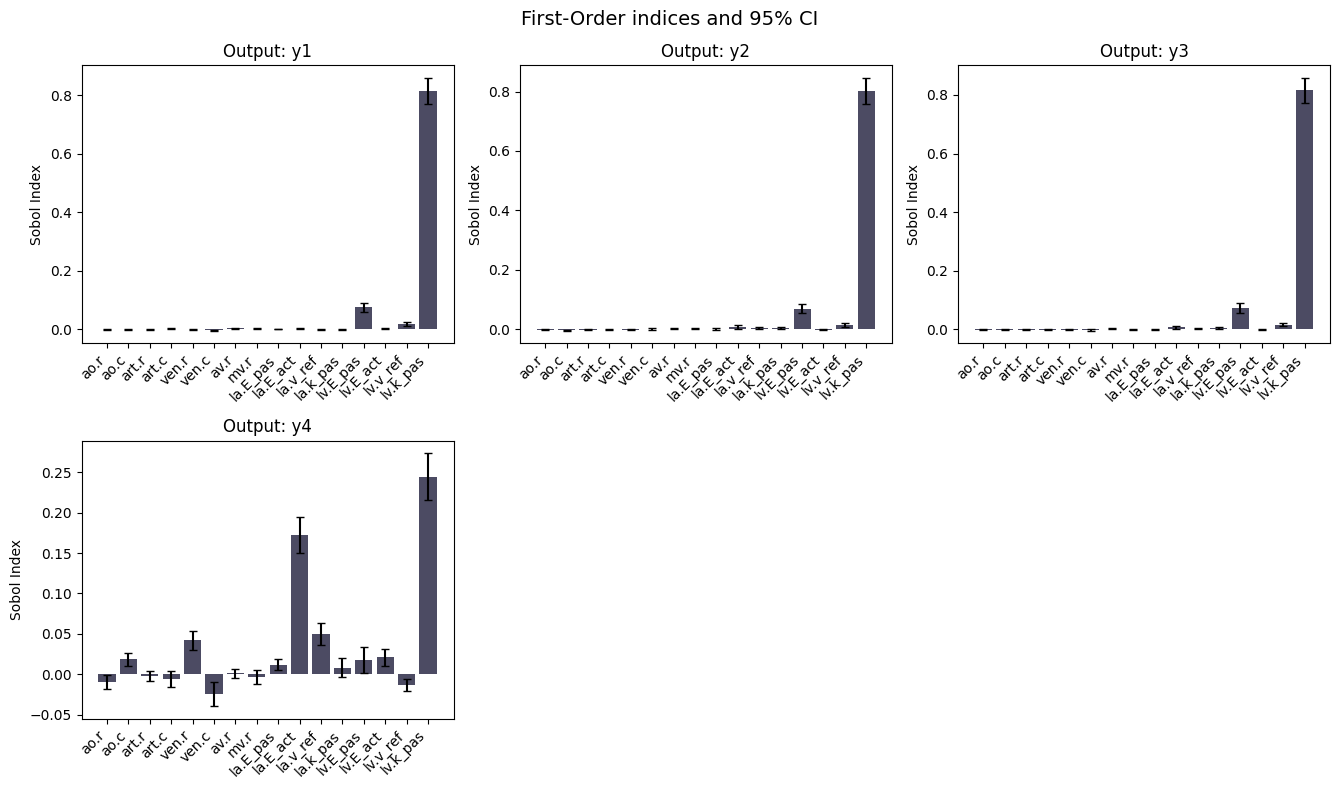

In [12]:
si.plot_sobol(si_df)

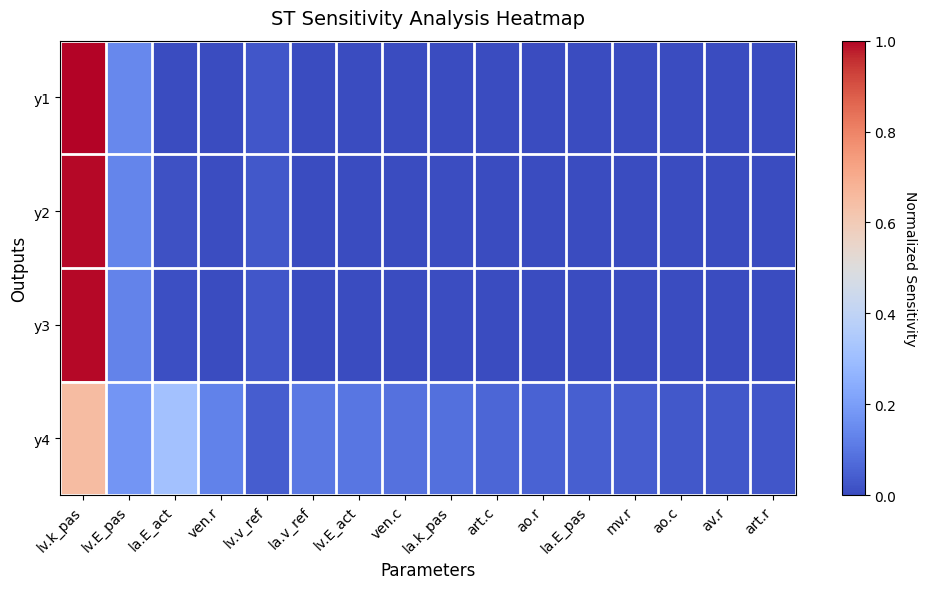

In [13]:
si.plot_sa_heatmap(si_df, index='ST', cmap='coolwarm', normalize=True, figsize=(10, 6))

We can select the top 3 parameters that have the biggest influcence on the pressure wave summary statistics extracted from the Naghavi Model.

In [14]:
n_parameters = 3
top_parameters_sa = si.top_n_sobol_params(si_df, top_n=n_parameters)
top_parameters_sa

['lv.k_pas', 'lv.E_pas', 'la.E_act']

The parameters that are found to be less influential are fixed to a mid point value within its range. This means that next time we sample from the parameter space we only sample from the top 3 parameters. When running the simulations we pass in the fixed values for the other parameters.

In [15]:
updated_range = {}
for param_name, (min_val, max_val) in simulator.parameters_range.items():
    if param_name not in top_parameters_sa:
        midpoint_value = (max_val + min_val) / 2.0
        updated_range[param_name] = (midpoint_value, midpoint_value)
    else:
        updated_range[param_name] = simulator.parameters_range[param_name]# Fix to a value
        
simulator.parameters_range = updated_range

In [16]:
print("Updated simulator parameters range with fixed values for non-sensitive parameters:")
for param, (a, b) in simulator.parameters_range.items():
    if a == b:
        print(f"{param} fixed to: {round(float(a), 3)}")
    else:
        print(f"{param} to sample from: {round(float(a), 3)} - {round(float(b), 3)}")

Updated simulator parameters range with fixed values for non-sensitive parameters:
ao.r fixed to: 240.0
ao.c fixed to: 0.3
art.r fixed to: 1125.0
art.c fixed to: 3.0
ven.r fixed to: 9.0
ven.c fixed to: 133.3
av.r fixed to: 6.0
mv.r fixed to: 4.1
la.E_pas fixed to: 0.44
la.E_act to sample from: 0.225 - 0.675
la.v_ref fixed to: 10.0
la.k_pas fixed to: 0.046
lv.E_pas to sample from: 0.5 - 1.5
lv.E_act fixed to: 3.0
lv.v_ref fixed to: 10.0
lv.k_pas to sample from: 0.01 - 0.045


### Patient level calibration

To refine our emulator, we need real-world observations to compare against. These observations can come from experiments reported in the literature. 

In this example, we'll generate synthetic "observations" by running the simulator at the midpoint of each parameter range, treating these as our "ground truth" values for calibration. Note that in a real world example one can have multiple observations.

In [17]:
# Calculate midpoint parameters
patient_true_values = {}
for param_name in simulator.parameters_range:
    # Calculate the midpoint of the parameter range
    min_val, max_val = simulator.parameters_range[param_name]
    patient_true_values[param_name] = (max_val + min_val) / 2.0

# Run the simulator with midpoint parameters
midpoint_results = simulator.forward(
    torch.tensor(list(patient_true_values.values())).reshape(1, -1)
)

In [18]:
# Create observations dictionary
observations = {
    name: (val.item(), max(abs(val.item()) * 0.05, 0.05)) for
    name, val in 
    zip(simulator.output_names, midpoint_results[0])}
observations

{'lv.P_min': (12.257057189941406, 0.6128528594970704),
 'lv.P_max': (22.596208572387695, 1.1298104286193849),
 'lv.P_mean': (20.69025421142578, 1.034512710571289),
 'lv.P_range': (10.339152336120605, 0.5169576168060303)}

### History Matching

Once the influential parameters have been selected with sensitivity analysis, we want to find which values of those parameters are consistent with the clinical data for a specific patient such as the observations generated above. Rather than directly estimating the parameters, history matching first focuses on excluding regions of the parameter space that are not plausible. 

Given emulator predictions for a number of possible parameter sets $f(θ)$ and observed data $y_{obs}$, history matching:
- Computes an implausibility measure for each parameter set: $I(\theta) = \frac{|y_{obs} - \mathbb{E}[f(\theta)]|}{\sqrt{\text{Var}[f(\theta)]}}$
- Rule out all $θ$ such that $I(θ)>$ threshold (e.g., 3).

The denominator in the implausability calculation can optionally include uncertainty in the observations or a model discrepancy term.

Since history matching requires predictive variance, below we train a Gaussian Process emulator. The emulator is trained on to predict the outputs given only the most sensitive parameters as inputs.

In [19]:
x = simulator.sample_inputs(500,random_seed=seed)
y, x = simulator.forward_batch(x)

Running simulations: 100%|██████████| 500/500 [02:11<00:00, 3.80sample/s]   


In [20]:
from autoemulate.emulators.gaussian_process.kernel import matern_3_2_kernel

sa_parameter_idx = [
    simulator.get_parameter_idx(param) for param in top_parameters_sa
]

ae_hm = AutoEmulate(
    # only use sensitive parameters as inputs to emulator
    x[:, sa_parameter_idx], 
    y, 
    models=["GaussianProcess"],  
    model_params = {
        'covar_module': matern_3_2_kernel,
        'standardize_x': True,
        'standardize_y': True
        
    }
)

res = ae_hm.best_result()
gp_matern = res.model

Comparing models: 100%|██████████| 1.00/1.00 [00:04<00:00, 4.67s/model]


We could now use the emulator to make predictions and evaluate those predictions against observations as described above.

However, we often want to run history matching iteratively and make use of the simulator to continually improve the emulator and the calibration results. 

To this end, AutoEmulate implements the `HistoryMatchingWorkflow`, which can run multiple "waves" of history matching. In each wave:
- new parameters are sampled from the not ruled out yet (NROY) space and evaluated on their plausability using an emulator
- new simulations are run for a subset of those parameters
- the emulator is retrained with the newly simulated data

The `HistoryMatchingWorkflow` object takes in the simulator, the trained emulator and observations. Since the emulator was trained on a subset of the simulation parameters, we need to specify which parameters those are. `HistoryMatchingWorkflow` can also optionally be passed the data the emulator was trained on to reuse when retraining the emulator.

In [21]:
from autoemulate.calibration.history_matching import HistoryMatchingWorkflow

hmw = HistoryMatchingWorkflow(
    simulator=simulator,
    result=ae_hm.best_result(),
    observations=observations,
    threshold=3.0,
    train_x=x.float(),
    train_y=y.float(),
    # specify subset of simulator parameters to calibrate
    # these are the input parameters the emulator was trained on
    calibration_params=top_parameters_sa,
)

The workflow is called with the `run_waves` method. The user can specify how many waves to run but when the NROY region changes little between waves (e.g., <10% of new points are excluded) then the workflow is stopped even if not all waves have been completed.

In [22]:
n_waves=5

history_matching_results = hmw.run_waves(
    n_waves=n_waves, 
    # the number of simulations to run each wave
    n_simulations=100, 
    # number of parameter samples to draw from which to select NROY samples to simulate
    n_test_samples=1000
)

INFO:autoemulate:Running history matching wave 1/5
DEBUG:autoemulate:Running history matching wave with 100 simulations and 1000 test samples
DEBUG:autoemulate:Generated 404 NROY samples on try 1, have 404 total NROY samples so far.
INFO:autoemulate:Running batch simulation for 100 samples
Running simulations: 100%|██████████| 100/100 [00:36<00:00, 2.71sample/s] 
INFO:autoemulate:Successfully completed 100/100 simulations (100.0%)
INFO:autoemulate:Refitting emulator on all data.
INFO:autoemulate:Wave 1/5: NROY fraction is 40.40%
INFO:autoemulate:Running history matching wave 2/5
DEBUG:autoemulate:Running history matching wave with 100 simulations and 1000 test samples
  warnings.warn(

DEBUG:autoemulate:Generated 96 NROY samples on try 1, have 96 total NROY samples so far.
DEBUG:autoemulate:Generated 124 NROY samples on try 2, have 220 total NROY samples so far.
INFO:autoemulate:Running batch simulation for 100 samples
Running simulations: 100%|██████████| 100/100 [00:44<00:00, 2.26sam

The below figure shows the implausibility scores for each parameter combination, allowing us to visualize which regions of the parameter space are plausible (i.e., not ruled out yet) based on the observed data in a given wave. 

In [23]:
# include the true value for reference
ref_val = {param: float(patient_true_values[param]) for param in top_parameters_sa}

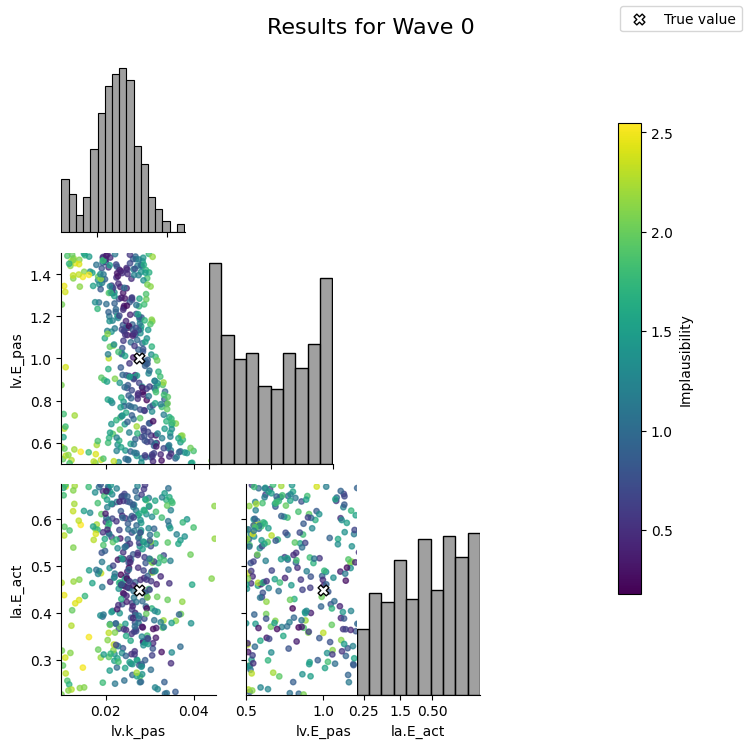

In [24]:
hmw.plot_wave(wave=0, ref_val=ref_val)

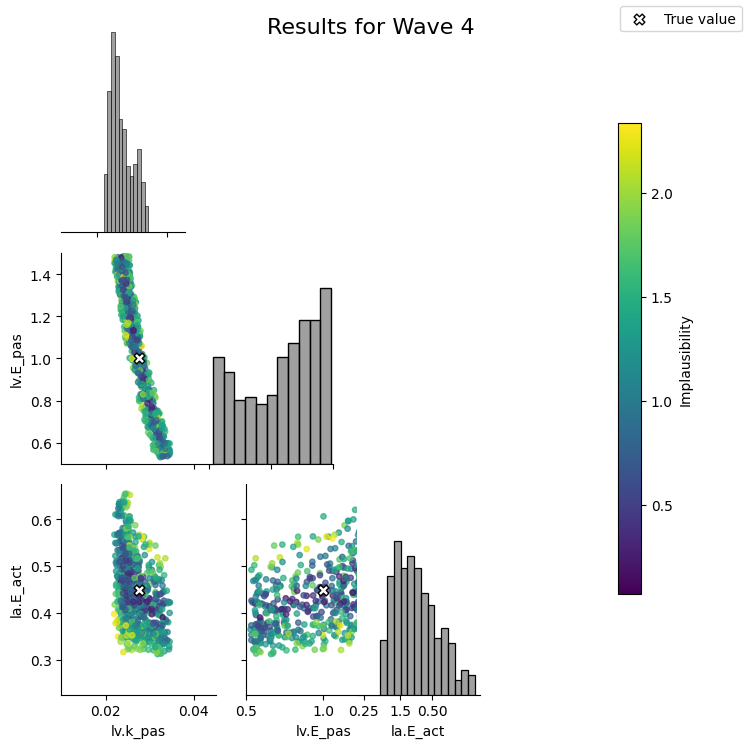

In [25]:
hmw.plot_wave(wave=4, ref_val=ref_val)

We can also  plot the evolution of the NROY space over the waves of history matching for a given parameter.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


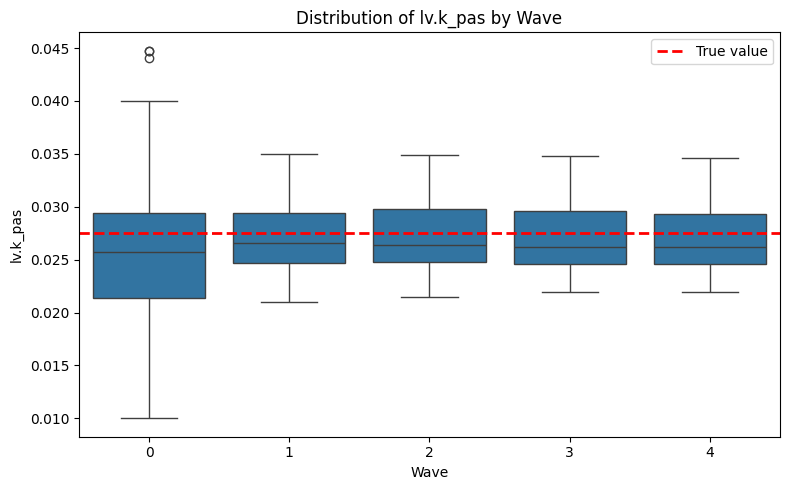

In [26]:
hmw.plot_wave_evolution(top_parameters_sa[0], ref_val=ref_val)

### Bayesian calibration

We can now use the reduced parameter space from history matching to constrain Bayesian inference to estimate the posterior distribution of parameters given the observed patient data. We apply the following steps:

- Define a prior over parameters using the NROY region from history matching.

- Define a likelihood function that compares model predictions to patient data, including observation and model error.

- Use a Bayesian method (MCMC) to sample from the posterior.



In [27]:
# Get the last wave results
test_parameters, impl_scores = hmw.wave_results[-1]
nroy_points = hmw.get_nroy(impl_scores,test_parameters) # Implausibility < 3.0

# Get exact min/max bounds for the parameters from the NROY points
params_post_hm = hmw.generate_param_bounds(
    nroy_x=nroy_points,
    param_names=simulator.param_names, 
    buffer_ratio=0.0
)

In [28]:
from autoemulate.calibration.bayes import BayesianCalibration

model_post_hm = hmw.emulator  # Use the emulator from history matching

bc = BayesianCalibration(
    emulator=model_post_hm,
    parameter_range={k:v for k,v in params_post_hm.items() if k in top_parameters_sa},
    observations = {k: torch.tensor(v[0]) for k,v in observations.items()},
    # take account of the emulator uncertainty
    model_uncertainty=True,
    # specify observation noise as variance
    observation_noise={k: v[1]**2 for k,v in observations.items()}
)

mcmc = bc.run_mcmc(warmup_steps=250, num_samples=1000, sampler='nuts')

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed
INFO:autoemulate:Initializing BayesianCalibration with parameters: ['la.E_act', 'lv.E_pas', 'lv.k_pas']
DEBUG:autoemulate:Observation for output 'lv.P_min' converted from 0D to 1D.
DEBUG:autoemulate:Observation for output 'lv.P_max' converted from 0D to 1D.
DEBUG:autoemulate:Observation for output 'lv.P_mean' converted from 0D to 1D.
DEBUG:autoemulate:Observation for output 'lv.P_range' converted from 0D to 1D.
INFO:autoemulate:Processed observations for outputs: ['lv.P_min', 'lv.P_max', 'lv.P_mean', 'lv.P_range']
DEBUG:autoemulate:Observation noise (variance) set as dict: {'lv.P_min': 0.3755886273937359, 'lv.P_max': 1.276471604617118, 'lv.P_mean': 1.0702165483335555, 'lv.P_range': 0.2672451775737704}
DEBUG:autoemulate:Using NUTS kernel.
INFO:autoemulate:Starting MCMC run.
Warmup:   0%|          | 0/1250 [00:00, ?it/s]WARNING:py.warnings:/Users/rjersakov

In [29]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  la.E_act      0.49      0.10      0.49      0.31      0.63    913.40      1.00
  lv.E_pas      1.00      0.27      1.01      0.53      1.39   1036.36      1.00
  lv.k_pas      0.03      0.00      0.03      0.02      0.03    703.18      1.01

Number of divergences: 0


We can check if the posterior samples are consistent with the true values of the parameters.

DEBUG:autoemulate:Using az.from_pyro for conversion.
  warnings.warn(

INFO:autoemulate:Arviz InferenceData conversion complete.


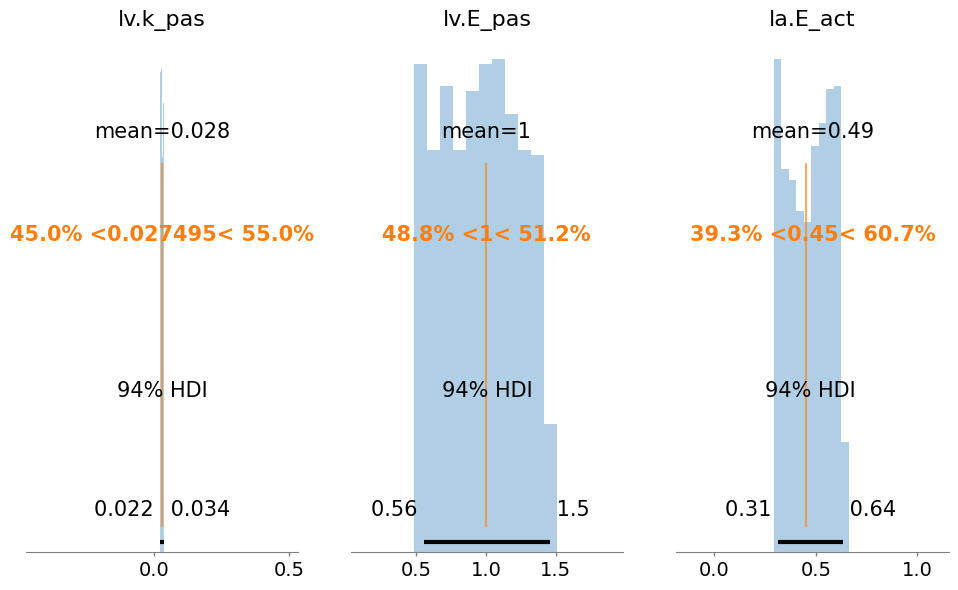

In [30]:
import arviz as az
import matplotlib.pyplot as plt
idata = bc.to_arviz(mcmc)

az.plot_posterior(
    idata, 
    var_names=top_parameters_sa, 
    kind='hist', 
    figsize=(10, 6), 
    ref_val=[ref_val[param] for param in top_parameters_sa]
)
plt.tight_layout()
plt.show()

In [31]:
output_name = f"results_waves_{n_waves}_sa_params_{n_parameters}.html"

!jupyter nbconvert --to html patient_calibration_case_study.ipynb  --output {output_name}

[NbConvertApp] Converting notebook patient_calibration_case_study.ipynb to html
[NbConvertApp] Writing 767712 bytes to results_waves_5_sa_params_3.html
